In [597]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dfply import *
from sklearn.externals import joblib

# Feature engineering

### <font color='red'>Still need to remove outliers--there are several</font> 

In [496]:
# import updated train/test data

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [497]:
# summary of response variable

train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/Users/rich/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Log of Response Variable')

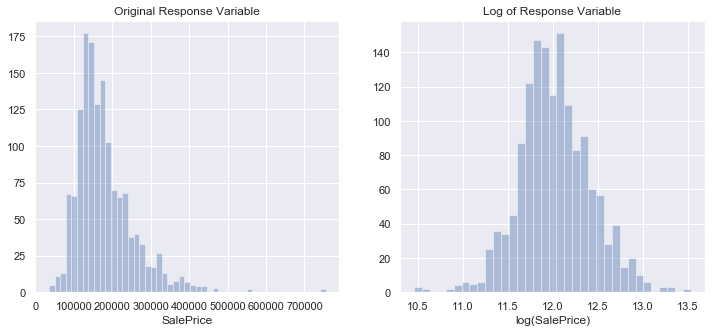

In [498]:
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.distplot(train['SalePrice'],kde=False)
plt.title('Original Response Variable')
plt.subplot(122)
sns.distplot(np.log(train['SalePrice']),kde=False)
plt.xlabel('log(SalePrice)')
plt.title('Log of Response Variable')

In [499]:
# create 'yrs since' variables

train = (train >>
     mutate(
         yrsSinceBlt = train.YrSold - train.YearBuilt,
         yrsSinceYrRnvd = train.YrSold - train.YearRemodAdd,
         yrsSinceGrgBlt = train.YrSold - train.GarageYrBlt,
         totalSF = train['1stFlrSF'] + train['2ndFlrSF']))

test = (test >>
     mutate(
         yrsSinceBlt = test.YrSold - test.YearBuilt,
         yrsSinceYrRnvd = test.YrSold - test.YearRemodAdd,
         yrsSinceGrgBlt = test.YrSold - test.GarageYrBlt,
         totalSF = test['1stFlrSF'] + test['2ndFlrSF']))

/Users/rich/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


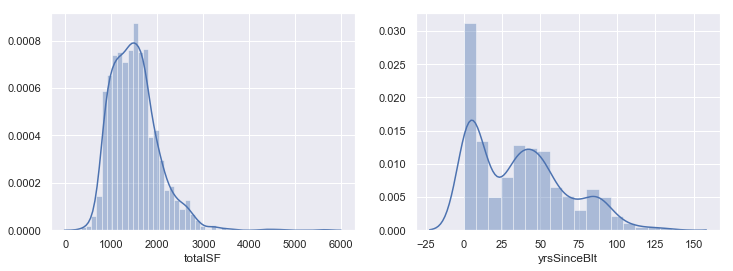

In [500]:
# checking the new variables (1 & 2 of 4)

plt.figure(figsize=(12,4))
plt.subplot(121)
sns.distplot(train.totalSF)
plt.subplot(122)
sns.distplot(train.yrsSinceBlt)

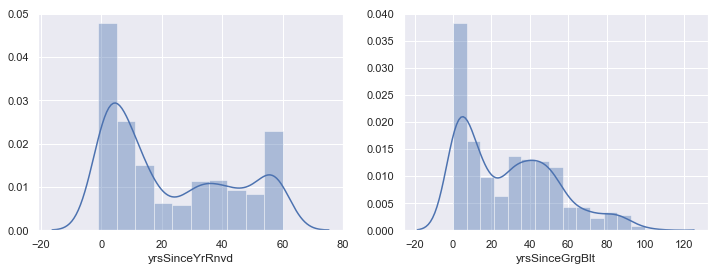

In [501]:
# checking the new variables (3 & 4 of 4)

plt.figure(figsize=(12,4))
plt.subplot(121)
sns.distplot(train.yrsSinceYrRnvd)
plt.subplot(122)
sns.distplot(train.yrsSinceGrgBlt.dropna())

In [502]:
# current list of numeric (num) and categorical (cat) variables

num = ['SalePrice','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
         'TotalBsmtSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath',
         'FullBath','HalfBath','TotRmsAbvGrd','Fireplaces',
         'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
         'ScreenPorch','PoolArea','MiscVal','yrsSinceBlt','yrsSinceYrRnvd','yrsSinceGrgBlt',
         'totalSF']

cats = ['MSSubClass','MSZoning','LotShape','LandContour',
          'LotConfig','LandSlope','Neighborhood','Condition1',
          'OverallQual','OverallCond',
          'RoofStyle','Exterior1st','MasVnrType',
          'ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond',
          'BsmtExposure','BsmtFinType1','HeatingQC',
          'CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
          'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive',
          'SaleType','SaleCondition']

In [503]:
# assess the extent of missingness

(round(train.isnull().mean() * 100,2)[round(train.isnull().mean() * 100,2) > 0]
     .sort_values(ascending=False))

# NaN in PoolQC actually means no pool
# NaN in MiscFeature actually means not applicable - this is a weird variable
# NaN in Alley actually means no alley
# NaN in Fence actually means no fence
# NaN in FirePlaceQu actually means no fireplace
# NaN in *all garage vars actually means no garage
# NaN in *all basement vars actually means no basement



PoolQC            99.52
MiscFeature       96.30
Alley             93.77
Fence             80.75
FireplaceQu       47.26
LotFrontage       17.74
GarageType         5.55
yrsSinceGrgBlt     5.55
GarageYrBlt        5.55
GarageFinish       5.55
GarageQual         5.55
GarageCond         5.55
BsmtFinType2       2.60
BsmtExposure       2.60
BsmtFinType1       2.53
BsmtCond           2.53
BsmtQual           2.53
MasVnrArea         0.55
MasVnrType         0.55
Electrical         0.07
dtype: float64

In [504]:
replaceNaN = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
              'GarageType','GarageFinish','GarageQual','GarageCond',
              'BsmtFinType2','BsmtExposure','BsmtFinType1','BsmtCond',
              'BsmtQual']

# look to see if there's already a 'none' category
# if not, replace NaN with 'none'

for i in replaceNaN:
    print(train[i].unique())

[nan 'Ex' 'Fa' 'Gd']
[nan 'Shed' 'Gar2' 'Othr' 'TenC']
[nan 'Grvl' 'Pave']
[nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
['RFn' 'Unf' 'Fin' nan]
['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
['No' 'Gd' 'Mn' 'Av' nan]
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
['TA' 'Gd' nan 'Fa' 'Po']
['Gd' 'TA' 'Ex' nan 'Fa']


In [505]:
train[replaceNaN] = train[replaceNaN].fillna(value='None')
test[replaceNaN] = test[replaceNaN].fillna(value='None')

for i in replaceNaN:
    print(train[i].unique())

['None' 'Ex' 'Fa' 'Gd']
['None' 'Shed' 'Gar2' 'Othr' 'TenC']
['None' 'Grvl' 'Pave']
['None' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'None' 'Basment' '2Types']
['RFn' 'Unf' 'Fin' 'None']
['TA' 'Fa' 'Gd' 'None' 'Ex' 'Po']
['TA' 'Fa' 'None' 'Gd' 'Po' 'Ex']
['Unf' 'BLQ' 'None' 'ALQ' 'Rec' 'LwQ' 'GLQ']
['No' 'Gd' 'Mn' 'Av' 'None']
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ']
['TA' 'Gd' 'None' 'Fa' 'Po']
['Gd' 'TA' 'Ex' 'None' 'Fa']


In [506]:
# are zeros in numeric garage vars true zeros

(train >>
    #arrange(train.yrsSinceBlt, ascending = False) >>
    select(train.Id, train.GarageType, train.GarageFinish, train.GarageCars, 
           train.GarageArea, train.GarageQual, train.GarageCond, train.yrsSinceGrgBlt, train.yrsSinceBlt) >>
    mask(train.GarageCond == 'None') >>
    head()) 

## all 81 without garage have 0 for GarageCars and Garage Area. This isn't correct
## replace these 0 with NaN

a = train['GarageCond'] == 'None' 
b = train['GarageArea'] == 0

train.loc[a & b, ['GarageArea','GarageCars']] = np.nan

a = test['GarageCond'] == 'None' 
b = test['GarageArea'] == 0

test.loc[a & b, ['GarageArea','GarageCars']] = np.nan


In [507]:
# duplicated values

print('Duplicated values:', train.duplicated().sum())
print('Duplicated values:', test.duplicated().sum())

Duplicated values: 0
Duplicated values: 0


In [508]:
## helper function to help differentiate var type

def print_dtype(dt, df):
    list = df.dtypes[df.dtypes == dt].index.tolist()
    x, y, z = [], [], []
    for l in list:
        a = df[l].unique()
        x.append(a)
        y.append(len(a))
        z.append(df[l].isnull().sum())
    tempdf = pd.DataFrame({'uniques': x, 'qty': y, 'na': z}, index=[list])
    print("\nData Frame 'tempdf' contains only", dt, "data")
    print(tempdf.sort_values('qty'))
    print(tempdf.sort_values('qty').T.columns.tolist())

In [509]:
print_dtype('float64', train)


Data Frame 'tempdf' contains only float64 data
                                                          uniques  qty   na
GarageCars                              [2.0, 3.0, 1.0, nan, 4.0]    5   81
GarageYrBlt     [2003.0, 1976.0, 2001.0, 1998.0, 2000.0, 1993....   98   81
yrsSinceGrgBlt  [5.0, 31.0, 7.0, 8.0, 16.0, 3.0, 36.0, 77.0, 6...  102   81
LotFrontage     [65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, nan...  111  259
MasVnrArea      [196.0, 0.0, 162.0, 350.0, 186.0, 240.0, 286.0...  328    8
GarageArea      [548.0, 460.0, 608.0, 642.0, 836.0, 480.0, 636...  441   81
[('GarageCars',), ('GarageYrBlt',), ('yrsSinceGrgBlt',), ('LotFrontage',), ('MasVnrArea',), ('GarageArea',)]


In [510]:
print_dtype('object', train)


Data Frame 'tempdf' contains only object data
                                                         uniques  qty  na
Street                                              [Pave, Grvl]    2   0
CentralAir                                                [Y, N]    2   0
Utilities                                       [AllPub, NoSeWa]    2   0
Alley                                         [None, Grvl, Pave]    3   0
LandSlope                                        [Gtl, Mod, Sev]    3   0
PavedDrive                                             [Y, N, P]    3   0
PoolQC                                        [None, Ex, Fa, Gd]    4   0
KitchenQual                                     [Gd, TA, Ex, Fa]    4   0
GarageFinish                               [RFn, Unf, Fin, None]    4   0
ExterQual                                       [Gd, TA, Ex, Fa]    4   0
LandContour                                 [Lvl, Bnk, Low, HLS]    4   0
LotShape                                    [Reg, IR1, IR2, IR3] 

In [511]:
# deprecated for better approach above

# count the number of unique values across variables
# i'm looking for constants here

#for i in train.columns:
#    print(i,train[i].nunique())
    
# none

In [512]:
pd.crosstab(train['BldgType'],columns='count')

for i in train[cats]:
    print(pd.crosstab(train[i],columns='count'))

col_0       count
MSSubClass       
20            536
30             69
40              4
45             12
50            144
60            299
70             60
75             16
80             58
85             20
90             52
120            87
160            63
180            10
190            30
col_0     count
MSZoning       
C (all)      10
FV           65
RH           16
RL         1151
RM          218
col_0     count
LotShape       
IR1         484
IR2          41
IR3          10
Reg         925
col_0        count
LandContour       
Bnk             63
HLS             50
Low             36
Lvl           1311
col_0      count
LotConfig       
Corner       263
CulDSac       94
FR2           47
FR3            4
Inside      1052
col_0      count
LandSlope       
Gtl         1382
Mod           65
Sev           13
col_0         count
Neighborhood       
Blmngtn          17
Blueste           2
BrDale           16
BrkSide          58
ClearCr          28
CollgCr         150
Crawfor 

In [513]:
surveyQues = ['SalePrice','OverallQual','OverallCond','ExterQual','ExterCond',
             'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
             'BsmtFinType2','KitchenQual','FireplaceQu','GarageQual',
             'GarageCond','PoolQC','Fence']

train[surveyQues].corr()

,SalePrice,OverallQual,OverallCond
SalePrice,1.000000,0.790982,-0.077856
OverallQual,0.790982,1.000000,-0.091932
OverallCond,-0.077856,-0.091932,1.000000


In [514]:
# need to drop following vars due to too little variability, just doesn't
# make sense to keep, or found better variable

# Utilities, Id, yearBuilt, yearRemod, yrSold,MoSold,Alley

train.drop(columns=['Id','Utilities','Street','YearBuilt','YearRemodAdd',
                   '1stFlrSF','2ndFlrSF','GarageYrBlt','MoSold','YrSold'], inplace=True)

test.drop(columns=['Id','Utilities','Street','YearBuilt','YearRemodAdd',
                   '1stFlrSF','2ndFlrSF','GarageYrBlt','MoSold','YrSold'], inplace=True)

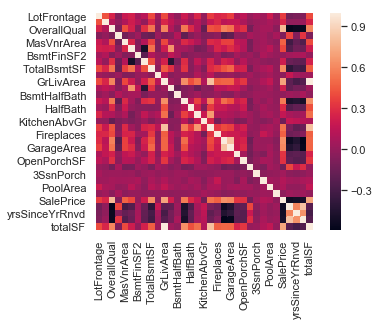

In [515]:
## correlations of numeric

sns.set(font_scale=1)  
sns.heatmap(train.iloc[:,1:].corr(), vmax=1, square=True)

In [516]:
corrYX = train.iloc[:,1:].corr()['SalePrice'].sort_values(axis=0,ascending=False).iloc[1:]
corrYX

OverallQual       0.790982
totalSF           0.716883
GrLivArea         0.708624
GarageCars        0.637095
TotalBsmtSF       0.613581
GarageArea        0.608405
FullBath          0.560664
TotRmsAbvGrd      0.533723
MasVnrArea        0.477493
Fireplaces        0.466929
BsmtFinSF1        0.386420
LotFrontage       0.351799
WoodDeckSF        0.324413
OpenPorchSF       0.315856
HalfBath          0.284108
LotArea           0.263843
BsmtFullBath      0.227122
BsmtUnfSF         0.214479
BedroomAbvGr      0.168213
ScreenPorch       0.111447
PoolArea          0.092404
3SsnPorch         0.044584
BsmtFinSF2       -0.011378
BsmtHalfBath     -0.016844
MiscVal          -0.021190
LowQualFinSF     -0.025606
OverallCond      -0.077856
EnclosedPorch    -0.128578
KitchenAbvGr     -0.135907
yrsSinceGrgBlt   -0.487069
yrsSinceYrRnvd   -0.509079
yrsSinceBlt      -0.523350
Name: SalePrice, dtype: float64

/Users/rich/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


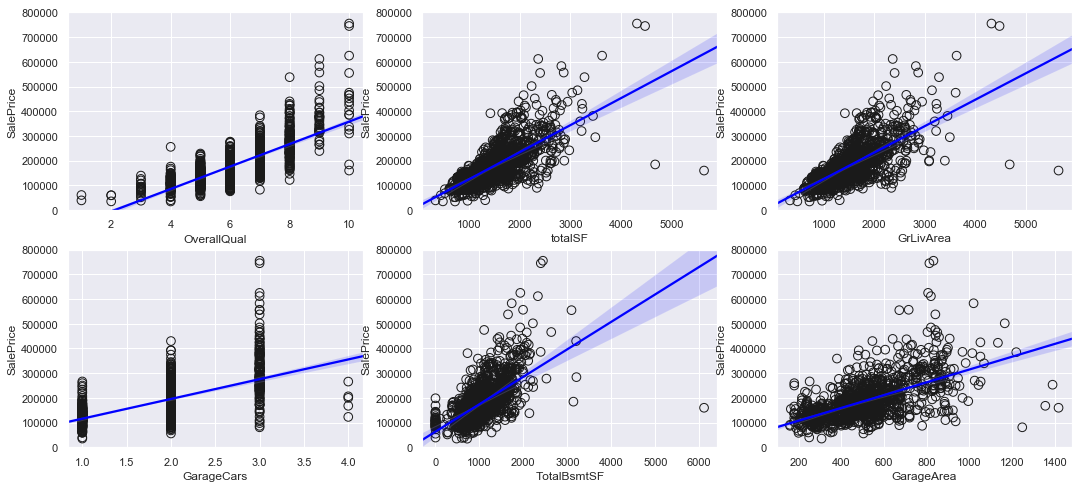

In [517]:
plt.figure(figsize=(18,8))
for i in range(6):
    ii = '23'+str(i+1)
    plt.subplot(ii)
    feature = corrYX.index.values[i]
    plt.scatter(train[feature], train['SalePrice'], facecolors='none',edgecolors='k',s = 75)
    sns.regplot(x = feature, y = 'SalePrice', data = train,scatter=False, color = 'Blue')
    ax=plt.gca() 
    ax.set_ylim([0,800000])

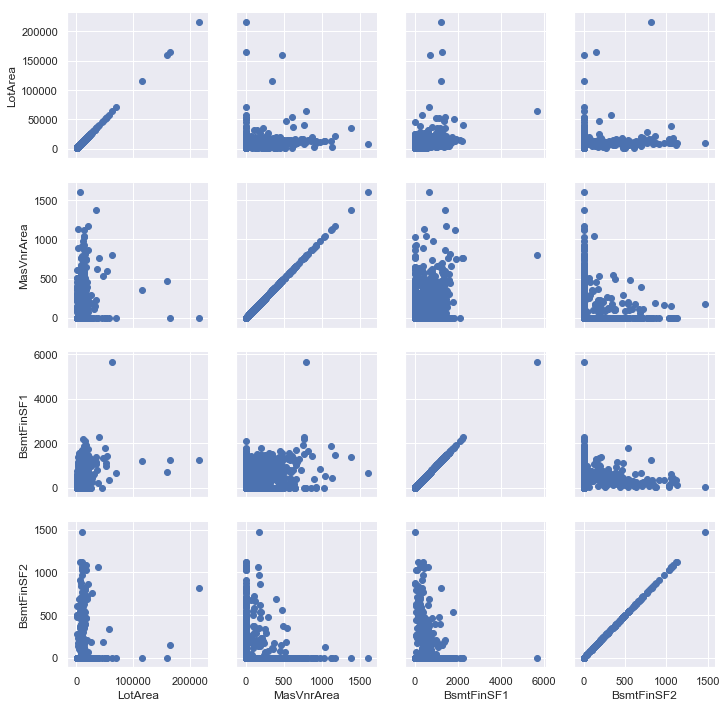

In [518]:
g = sns.PairGrid(train[num[1:5]]) # index 0 is the response var
g.map(plt.scatter)

In [525]:
# separate DV from training set for scikit-learn

X_train, y_train = train.loc[:,train.columns != 'SalePrice'], np.log(train.loc[:,train.columns == 'SalePrice'])
X_test = test.loc[:,test.columns != 'SalePrice']

X_train.shape

(1460, 74)

In [536]:
# final list of features

num_features = ['totalSF','3SsnPorch','BedroomAbvGr','EnclosedPorch',
      'Fireplaces','FullBath','GrLivArea','HalfBath','KitchenAbvGr',
      'LotArea','LowQualFinSF','MiscVal','OpenPorchSF','OverallQual',
      'OverallCond','PoolArea','ScreenPorch','TotRmsAbvGrd','WoodDeckSF',
      'yrsSinceBlt','yrsSinceYrRnvd','yrsSinceGrgBlt','BsmtHalfBath',
      'BsmtFullBath','GarageCars','BsmtFinSF2','MasVnrArea',
      'BsmtFinSF1','GarageArea','TotalBsmtSF','BsmtUnfSF']

cat_features = ['MSSubClass','BldgType','BsmtCond','BsmtExposure','BsmtFinType1',
      'BsmtFinType2','BsmtQual','CentralAir','Condition1','Condition2',
      'Electrical','ExterCond','ExterQual','Exterior1st','Exterior2nd',
      'Fence','Alley','FireplaceQu','Foundation','Functional','GarageCond',
      'GarageFinish','GarageQual','GarageType','HeatingQC',
      'HouseStyle','KitchenQual','LandContour','LandSlope','LotConfig',
      'LotShape','MSZoning','MasVnrType','MiscFeature','Neighborhood',
      'PavedDrive','PoolQC','RoofStyle','SaleCondition','SaleType']

In [537]:
# create a pipeline for further feature engineering
# imputing missing values, standardizing numeric variagles, 
# one hot encoding categorical variables

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# numeric
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# categorical
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [538]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])

In [577]:
# add classifier to preprocessing pipeline.
# now we have a full prediction pipeline.

clf = Pipeline(steps=[('preprocessor', preprocessor)])

X_train_adj = clf.fit_transform(X_train)
X_test_adj = clf.transform(X_test)

In [578]:
## little helper function to print results

def display_scores(scores):
    scores_star = [ '%.2f' % elem for elem in scores ]
    print("Mean:", scores_star)
    print("Mean:", round(scores.mean(),2))
    print("Standard deviation:", round(scores.std(),2))

# Model fittings

### Approach here is to choose algorithm/model & their appropriate hyperparameter values using nested 10-fold cross validation. Comparing a baseline linear regression model, ridge regression model, and random forest algorithm

## Baseline model: Linear Regression

In [579]:
## prep a regression

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# create linear regression object

regr = linear_model.LinearRegression()

In [580]:
# using 10-fold cross validation

from sklearn.model_selection import cross_val_score

linReg_scores = cross_val_score(estimator=regr, 
                                cv=10, 
                                X=X_train_adj, y=y_train,
                                scoring='neg_mean_squared_error')

In [581]:
## remember: -MSE, so bigger is *better*
## to convert to RMSE: -sqrt(-MSE)

linReg_rmse_scores = np.sqrt(-linReg_scores)

display_scores(linReg_rmse_scores)

Mean: ['0.13', '0.12', '0.12', '0.18', '0.15', '0.22', '0.14', '0.10', '0.25', '0.39']
Mean: 0.18
Standard deviation: 0.08


# Ridge regression

In [544]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge_reg = Ridge()
param_grid_ridge = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}

In [545]:
# grid search to determine best alpha hyperparameter value

ridgeReg_grid = GridSearchCV(estimator = ridge_reg, 
                            param_grid=param_grid_ridge, 
                            cv = 10, 
                            scoring='neg_mean_squared_error')

# Fit the random search model
ridgeReg_grid.fit(X_train_adj, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [546]:
ridgeReg_grid.best_params_

{'alpha': 20}

In [582]:
# refit to full training set with best estimator
ridge_reg = Ridge(alpha=20)
ridgeReg_scores = cross_val_score(estimator=ridge_reg, 
                                cv=10, 
                                X=X_train_adj, y=y_train,
                                scoring='neg_mean_squared_error')

In [583]:
## remember: -MSE, so bigger is *better*
## to convert to RMSE: -sqrt(-MSE)

rRidgeReg_rmse_scores = np.sqrt(-ridgeReg_scores)

display_scores(rRidgeReg_rmse_scores)

Mean: ['0.12', '0.10', '0.12', '0.17', '0.14', '0.11', '0.13', '0.10', '0.22', '0.13']
Mean: 0.13
Standard deviation: 0.04


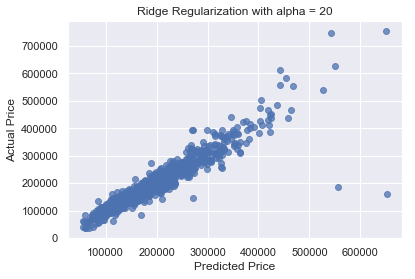

In [600]:
final_model = ridgeReg_grid.best_estimator_
rRidgeReg_pred = np.exp(final_model.predict(X_train_adj))

plt.scatter(rRidgeReg_pred, np.exp(y_train), alpha=.75, color='b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Ridge Regularization with alpha = 20')
plt.show()

# Random forest

In [586]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=500)

param_grid_forest = {'max_depth': [10,20,30,40,50]}

In [587]:
# grid search to find best max_depth hyperparamter value

forestReg_grid = GridSearchCV(estimator = forest_reg, 
                            param_grid=param_grid_forest, 
                            cv = 10, 
                            scoring='neg_mean_squared_error')

# Fit the random search model
forestReg_grid.fit(X_train_adj, y_train.values.ravel())

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [588]:
forestReg_grid.best_params_

{'max_depth': 50}

In [589]:
# refit with best estimator
forest_reg = RandomForestRegressor(n_estimators=500, max_depth=50)

forestReg_scores = cross_val_score(estimator=forest_reg, 
                                cv=10, 
                                X=X_train_adj, y=y_train.values.ravel(),
                                scoring='neg_mean_squared_error')

joblib.dump(forestReg_scores, 'saved_fullTrainedForest.pkl') 

In [590]:
## remember: -MSE, so bigger is *better*
## to convert to RMSE: -sqrt(-MSE)

forestReg_rmse_scores = np.sqrt(-forestReg_scores)

display_scores(forestReg_rmse_scores)

Mean: ['0.14', '0.12', '0.13', '0.17', '0.17', '0.11', '0.13', '0.12', '0.14', '0.15']
Mean: 0.14
Standard deviation: 0.02


## Random forest and ridge regression performed similarly--go with Ridge

In [591]:
## eval on test set using random forest
final_model = ridgeReg_grid.best_estimator_
y_hat_log = final_model.predict(X_test_adj)
y_hat = np.exp(y_hat_log)

In [595]:
## prep for submission
t = pd.read_csv('./test.csv') # i need Id
submission = pd.DataFrame()
submission['Id'] = t.Id
submission['SalePrice'] = y_hat
submission.head()


,Id,SalePrice
0,1461,114980.936765
1,1462,148080.433039
2,1463,170644.732885
3,1464,196435.721685
4,1465,195022.333340


In [596]:
submission.to_csv('submission1.csv', index=False)